In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
import datetime
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from mlxtend.evaluate import permutation_test

In [10]:
def findWaldtest(p1, p2,var1, var2, n , m):
    denominator = float(var1)/n + float(var2)/m
    denominator = np.sqrt(denominator)
    return abs(float(p1-p2)/denominator)

In [34]:
def getCommonDates(df1, df2):
    len1 = len(df1)
    len2 = len(df2)
    i = 0
    j =0
    list1 = list()
    list2 = list()
    while True:
        if i < len1 and j < len2:
            diff = (df1.loc[i,'FL_DATE'] - df2.loc[j,'FL_DATE']).days
            if diff == 0:
                list1.append(df1.loc[i,'DEP_DELAY'])
                list2.append(df2.loc[j,'DEP_DELAY'])
                i+=1
                j+=1
            elif diff > 0:
                list1.append(0)
                list2.append(df2.loc[j,'DEP_DELAY'])
                j+=1
            elif diff < 0:
                list1.append(df1.loc[i,'DEP_DELAY'])
                list2.append(0)
                i+=1
        elif i < len1:
            list1.append(df1.loc[i,'DEP_DELAY'])
            list2.append(0)
            i+=1
        elif j < len2:
            list1.append(0)
            list2.append(df2.loc[j,'DEP_DELAY'])
            j+=1
        else:
            return (list1, list2)

## Topic 2: Causality

### Hypothesis 1:  A ripple effect is observed when one flight gets delayed on arrival at an airport

In [52]:
corr = pd.read_csv('flight_delay_prediction/Data/flight_delays_2017.csv', delimiter = ',')

In [53]:
df1 = corr.loc[(corr['DEST'] == 'LAX')  & (corr['ARR_DELAY'] > 50) & (corr['CARRIER_NAME'] == 'JetBlue Airlines')]
df2 = corr.loc[(corr['ORIGIN'] == 'LAX') & (corr['DEP_DELAY'] > 0) & (corr['CARRIER_NAME'] == 'JetBlue Airlines')]

In [54]:
origin_airports = list(df1['ORIGIN'].unique())
dest_airports = list(df1['DEST'].unique())

in_first = set(origin_airports)
in_second = set(dest_airports)

in_second_but_not_in_first = in_second - in_first
result_airports = origin_airports + list(in_second_but_not_in_first)

airline_carrier = list(df1['CARRIER'].unique())

origin_airports = list(df2['ORIGIN'].unique())
dest_airports = list(df2['DEST'].unique())

in_first = set(origin_airports)
in_second = set(dest_airports)

in_second_but_not_in_first = in_second - in_first
result_airports = origin_airports + list(in_second_but_not_in_first)

airline_carrier = list(df2['CARRIER'].unique())

#Calcualte the schedule departure, departure time - departure delay
        
def get_time_in_min(x):
    val = x
    if len(x) == 4:
        pass
    elif len(x) == 3:
        val = '0' + val
    elif len(x) == 2:
        val = '00' + val
    elif len(x) == 1:
        val = '000'+ val
    hours = int(val[:2])*60 
    mins = int(val[2:])
    return hours+mins

def get_hour_from_min(x): 
    return int(x/60)

def getWeekDay(df):
    year, month, day = (int(x) for x in df['FL_DATE'].split('-'))    
    answer = datetime.date(year, month, day).weekday()
    return answer

def get_airport_id(x):
    return result_airports.index(x)

def get_airline_carrier_code(x):
    return airline_carrier.index(x)

def check_for_negative(x):
    if x<0:
        return x+1440
    else:
        return x

In [55]:
df1['SCHEDULE_DEP']  = df1['DEP_TIME'].astype('int32')
df1['SCHEDULE_DEP']  = df1['SCHEDULE_DEP'].astype(str)
df1['SCHEDULE_DEP'] = df1['SCHEDULE_DEP'].apply(get_time_in_min)
df1['SCHEDULE_DEP'] = df1['SCHEDULE_DEP'] - df1['DEP_DELAY']
df1['SCHEDULE_DEP'] = df1['SCHEDULE_DEP'].apply(check_for_negative)
df1['SCHEDULE_DEP'] = df1['SCHEDULE_DEP'].apply(get_hour_from_min)

df1['SCHEDULE_ARR']  = df1['ARR_TIME'].astype('int32')
df1['SCHEDULE_ARR']  = df1['SCHEDULE_ARR'].astype(str)
df1['SCHEDULE_ARR'] = df1['SCHEDULE_ARR'].apply(get_time_in_min)
df1['SCHEDULE_ARR'] = df1['SCHEDULE_ARR'] - df1['ARR_DELAY']
df1['SCHEDULE_ARR'] = df1['SCHEDULE_ARR'].apply(check_for_negative)
df1['SCHEDULE_ARR'] = df1['SCHEDULE_ARR'].apply(get_hour_from_min)

df2['SCHEDULE_DEP']  = df2['DEP_TIME'].astype('int32')
df2['SCHEDULE_DEP']  = df2['SCHEDULE_DEP'].astype(str)
df2['SCHEDULE_DEP'] = df2['SCHEDULE_DEP'].apply(get_time_in_min)
df2['SCHEDULE_DEP'] = df2['SCHEDULE_DEP'] - df2['DEP_DELAY']
df2['SCHEDULE_DEP'] = df2['SCHEDULE_DEP'].apply(check_for_negative)
df2['SCHEDULE_DEP'] = df2['SCHEDULE_DEP'].apply(get_hour_from_min)

df2['SCHEDULE_ARR']  = df2['ARR_TIME'].astype('int32')
df2['SCHEDULE_ARR']  = df2['SCHEDULE_ARR'].astype(str)
df2['SCHEDULE_ARR'] = df2['SCHEDULE_ARR'].apply(get_time_in_min)
df2['SCHEDULE_ARR'] = df2['SCHEDULE_ARR'] - df2['ARR_DELAY']
df2['SCHEDULE_ARR'] = df2['SCHEDULE_ARR'].apply(check_for_negative)
df2['SCHEDULE_ARR'] = df2['SCHEDULE_ARR'].apply(get_hour_from_min)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

In [ ]:
df1 = df1.drop(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'CARRIER', 'FL_NUM',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_NM', 'DEP_TIME', 'ARR_TIME', 'CANCELLED', 'CANCELLATION_CODE', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY',
       'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_NAME'], axis = 1)

In [66]:
df3 = pd.merge(df1, df2, on=['FL_DATE'])

In [67]:
temp = df3.groupby(['FL_DATE'])[['ARR_DELAY_x', 'DEP_DELAY_y']].mean().reset_index()

In [68]:
try1 = (temp['ARR_DELAY_x'] - temp['ARR_DELAY_x'].mean()) / temp['ARR_DELAY_x'].std()
try2 = (temp['DEP_DELAY_y'] - temp['DEP_DELAY_y'].mean()) / temp['DEP_DELAY_y'].std()

In [69]:
print('Critical value: 0.14')
print(ks_2samp(try1, try2))

Critical value: 0.14
Ks_2sampResult(statistic=0.092896174863388, pvalue=0.391599447832356)


### Hypothesis 2 :A disruption in operations of a certain airline causes carrier  	     delays over certain period of time


In [49]:
data = pd.read_csv('flight_delay_prediction/Data/flight_delays_2016.csv', delimiter = ',')

In [50]:
hypo1_data = data.groupby(['MONTH','CARRIER_NAME'])['CARRIER_DELAY'].mean().reset_index()

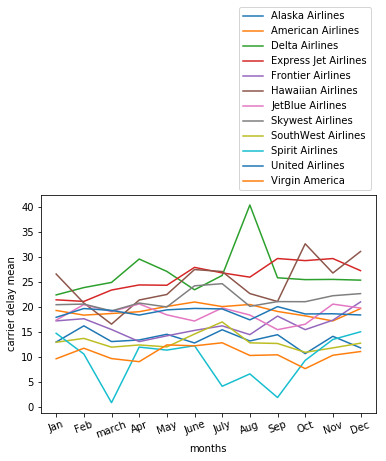

In [51]:
cols = hypo1_data.CARRIER_NAME.unique()
cols = list(cols)
months =['Jan', 'Feb', 'march','Apr','May','June', 'July','Aug','Sep', 'Oct','Nov','Dec']
for i in range(len(cols)):
    airline_month_data = hypo1_data[hypo1_data.CARRIER_NAME == cols[i]]
    plt.plot(airline_month_data.MONTH, airline_month_data.CARRIER_DELAY)
    plt.xticks(airline_month_data.MONTH, months, rotation=20)
plt.legend(cols, loc= 'lower right', bbox_to_anchor=(1, 1))
plt.xlabel('months')
plt.ylabel('carrier delay mean')
plt.show()

In [6]:
### Testing this using a wald's test hypothesis
aug_data = data.loc[(data['MONTH'] == 8) & (data['CARRIER_NAME'] == 'Delta Airlines')].reset_index(drop=True)
yearly_data = data.loc[(data['CARRIER_NAME'] == 'Delta Airlines')].reset_index(drop=True)

In [7]:
## distribution of mean delay every day in august for delta airlines
#distribution_1 = month aug
#distribution_2 = yearly
distribution_1 = aug_data.groupby(['DAY_OF_MONTH'])['CARRIER_DELAY'].mean().reset_index()
distribution_2 = yearly_data.groupby(['DAY_OF_MONTH'])['CARRIER_DELAY'].mean().reset_index()

In [8]:
# August month
mean1 = np.mean(distribution_1['CARRIER_DELAY'])
var1 = np.var(distribution_1['CARRIER_DELAY'])

# All year 
mean2 = np.mean(distribution_2['CARRIER_DELAY'])
var2 = np.var(distribution_2['CARRIER_DELAY'])

Null hypothesis is that mean delay each day in delta airlines in august is equal to the mean delay each day in 2016 <br>
Alt hypothesis- delta airlines mean delay in august > whole year mean delay every day

In [12]:
## Applying wald test
print ("Critical value for upper tailed on 95% confidence interval is :", 1.645)
wald_value = findWaldtest(mean1, mean2,var1, var2, 31 , 31)
print ("Wald test value",wald_value)

print ("So, we reject the null hypothesis")

Critical value for upper tailed on 95% confidence interval is : 1.645
Wald test value 1.8889731103861525
So, we reject the null hypothesis


### Hypothesis 3: Nearby airports will be affected due to delay at a certain airport.

In [14]:
data_4 = pd.read_csv('flight_delay_prediction/Data/flight_delays_2016.csv', delimiter=',')
data_4 = data_4.drop(['Unnamed: 0'], axis =1)
data_4 = data_4.loc[data_4.DEP_DELAY > 0]

##### Airports in California

In [16]:
## Airorts in California
airports = ['LAX','SJC','PSP','SNA']
data_4 = data_4.loc[data_4.ORIGIN.isin(airports)]
data_4.head(3)

,YEAR,MONTH,DAY_OF_MONTH,FL_DATE,CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,...,CANCELLATION_CODE,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CARRIER_NAME
73,2016,1,2,2016-01-02,DL,2191,LAX,"Los Angeles, CA",California,PDX,...,0.0,140.0,113.0,834.0,1.0,0.0,0.0,0.0,17.0,Delta Airlines
76,2016,1,2,2016-01-02,DL,2204,LAX,"Los Angeles, CA",California,SLC,...,0.0,103.0,78.0,590.0,19.0,0.0,0.0,0.0,0.0,Delta Airlines
96,2016,1,2,2016-01-02,DL,2377,LAX,"Los Angeles, CA",California,SLC,...,0.0,119.0,94.0,590.0,11.0,0.0,5.0,0.0,0.0,Delta Airlines


In [17]:
LAX_data = data_4.loc[data_4.ORIGIN == 'LAX'].reset_index(drop=True)
SJC_data = data_4.loc[data_4.ORIGIN == 'SJC'].reset_index(drop=True)
PSP_data = data_4.loc[data_4.ORIGIN == 'PSP'].reset_index(drop=True)
SNA_data = data_4.loc[data_4.ORIGIN == 'SNA'].reset_index(drop=True)

In [21]:
LAX_delay = LAX_data.groupby(['FL_DATE'])['DEP_DELAY'].mean().reset_index()
SJC_delay = SJC_data.groupby(['FL_DATE'])['DEP_DELAY'].mean().reset_index()
PSP_delay = PSP_data.groupby(['FL_DATE'])['DEP_DELAY'].mean().reset_index()
SNA_delay = SNA_data.groupby(['FL_DATE'])['DEP_DELAY'].mean().reset_index()
LAX_delay['FL_DATE'] = pd.to_datetime(LAX_delay['FL_DATE'])
SJC_delay['FL_DATE'] = pd.to_datetime(SJC_delay['FL_DATE'])
PSP_delay['FL_DATE'] = pd.to_datetime(PSP_delay['FL_DATE'])
SNA_delay['FL_DATE'] = pd.to_datetime(SNA_delay['FL_DATE'])

In [26]:
## LAX vs SJC
LAX_delay_list, SJC_delay_list = getCommonDates(LAX_delay,SJC_delay)
print (ks_2samp(LAX_delay_list, SJC_delay_list))
print ("Critical value :", 1.3581/ np.sqrt(len(SJC_delay_list)))
print ("So we will reject the null hypothesis that the delays are same")

Ks_2sampResult(statistic=0.3333333333333333, pvalue=2.0117298394300446e-18)
Critical value : 0.0709890242035841
So we will reject the null hypothesis that the delays are same


In [27]:
## LAX vs PSP
LAX_delay_list, PSP_delay_list = getCommonDates(LAX_delay,PSP_delay)
print (ks_2samp(LAX_delay_list, PSP_delay_list))
print ("Critical value :", 1.3581/ np.sqrt(len(PSP_delay_list)))
print ("So we will reject the null hypothesis that the delays are same")

Ks_2sampResult(statistic=0.3797814207650274, pvalue=8.678216492709886e-24)
Critical value : 0.0709890242035841
So we will reject the null hypothesis that the delays are same


In [28]:
## LAX vs SNA
LAX_delay_list, SNA_delay_list = getCommonDates(LAX_delay,SNA_delay)
print (ks_2samp(LAX_delay_list, SNA_delay_list))
print ("Critical value :", 1.3581/ np.sqrt(len(SNA_delay_list)))
print ("So we will reject the null hypothesis that the delays are same")

Ks_2sampResult(statistic=0.2622950819672131, pvalue=1.4361886856463595e-11)
Critical value : 0.0709890242035841
So we will reject the null hypothesis that the delays are same


In [29]:
## SJC vs PSP
SJC_delay_list, PSP_delay_list = getCommonDates(SJC_delay,PSP_delay)
print (ks_2samp(SJC_delay_list, PSP_delay_list))
print ("Critical value :", 1.3581/ np.sqrt(len(PSP_delay_list)))
print ("So we will reject the null hypothesis that the delays are same")

Ks_2sampResult(statistic=0.3579234972677596, pvalue=3.550282729584291e-21)
Critical value : 0.0709890242035841
So we will reject the null hypothesis that the delays are same


In [30]:
## SJC vs SNA
SJC_delay_list, SNA_delay_list = getCommonDates(SJC_delay,SNA_delay)
print (ks_2samp(SJC_delay_list, SNA_delay_list))
print ("Critical value :", 1.3581/ np.sqrt(len(SJC_delay_list)))
print ("So we will reject the null hypothesis that the delays are same")

Ks_2sampResult(statistic=0.09562841530054644, pvalue=0.06603387554806275)
Critical value : 0.0709890242035841
So we will reject the null hypothesis that the delays are same


In [31]:
## PSP vs SNA
PSP_delay_list, SNA_delay_list = getCommonDates(PSP_delay,SNA_delay)
print (ks_2samp(PSP_delay_list, SNA_delay_list))
print ("Critical value :", 1.3581/ np.sqrt(len(PSP_delay_list)))
print ("So we will reject the null hypothesis that the delays are same")

Ks_2sampResult(statistic=0.32513661202185795, pvalue=1.5059412266856156e-17)
Critical value : 0.0709890242035841
So we will reject the null hypothesis that the delays are same
